# Overview
With the kernel I am trying to run a simple test on using Siamese networks for similarity on a slightly more complicated problem than standard MNIST.  The idea is to take a randomly initialized network and apply it to images to find out how similar they are. The models should make it much easier to perform tasks like Visual Search on a database of images since it will have a simple similarity metric between 0 and 1 instead of 2D arrays.

 * [Source Blog Post](http://sujitpal.blogspot.ch/2017/04/predicting-image-similarity-using.html) with this [notebook](https://github.com/sujitpal/holiday-similarity/blob/master/src/02-holidays-siamese-network.ipynb)

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load and Organize Data
Here we load and organize the data so we can easily use it inside of Keras models

In [142]:
from sklearn.model_selection import train_test_split
data_train_ori = pd.read_csv('../data/out/coraux_geov2.csv')
data_train = data_train_ori


In [184]:
# data_train = data_train_ori[:1000]
data_train = data_train_ori
data_train = data_train.dropna()
data_train['counts'] = data_train.groupby("species")["species"].transform('count')
data_train = data_train.sort_values("counts", ascending=False)  
data_train = data_train[data_train.counts < 500 ]
data_train = data_train[data_train.counts > 200 ]
data_train = data_train[:5000]
data_train = data_train.reset_index(drop=True)


/home/elodiedellier/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [185]:
X_full = data_train.loc[:,['temperature.csv', 'DepthInMeters', 'phosphate.csv', 'oxygen.csv', 'salinity.csv', 'nitrate.csv']]
y_full = data_train.loc[:,"species"]

X_full.head()
X_full.head()

,temperature.csv,DepthInMeters,phosphate.csv,oxygen.csv,salinity.csv,nitrate.csv
0,14.284375,277,0.756245,3.467705,35.649982,13.862911
1,10.845626,353,1.637408,2.733866,35.296623,25.430199
2,10.845586,354,1.637395,2.733871,35.296643,25.430279
3,10.855098,362,1.638615,2.733442,35.294186,25.422898
4,10.845626,353,1.637408,2.733866,35.296623,25.430199


In [186]:
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [187]:
# x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
# x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
# y_train = y_train.values.astype('int')
# y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

('Training', (3500, 6), temperature.csv      26.448787
DepthInMeters      2790.000000
phosphate.csv         3.362834
oxygen.csv            6.633403
salinity.csv         38.437554
nitrate.csv          43.975767
dtype: float64)
('Testing', (1500, 6), temperature.csv      25.277880
DepthInMeters      2795.000000
phosphate.csv         3.327653
oxygen.csv            6.838360
salinity.csv         36.854934
nitrate.csv          43.363912
dtype: float64)


In [188]:
# reorganize by groups

train_groups = [x_train.iloc[np.where(y_train==i)[0]].values for i in np.unique(y_train)]
test_groups = [x_test.iloc[np.where(y_test==i)[0]].values for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])


('train groups:', [336, 307, 327, 306, 288, 317, 209, 276, 281, 288, 271, 294])
('test groups:', [125, 148, 128, 123, 125, 139, 78, 111, 133, 141, 121, 128])


### Batch Generation
Here the idea is to make usuable batches for training the network. We need to create parallel inputs for the $A$ and $B$ images where the output is the distance. Here we make the naive assumption that if images are in the same group the similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

In [189]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

## Validate Data
Here we make sure the generator is doing something sensible, we show the images and their similarity percentage.

IndexError: too many indices for array

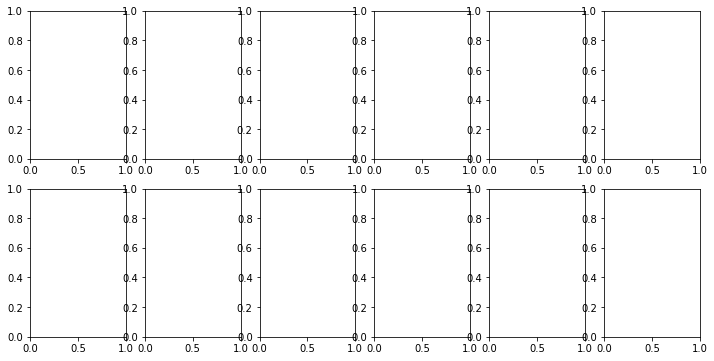

In [190]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
#     ax1.imshow(c_a[:,:,0])
    print(c_a[:,:])
    ax1.set_title('Image A')
    ax1.axis('off')
    print(c_b[:,:])
#     ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

# Feature Generation
Here we make the feature generation network to process images into features. The network starts off randomly initialized and will be trained to generate useful vector features from input images (_hopefully_)

In [191]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
print( x_train.shape[1:])
# img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')

n_layer = img_in
print(n_layer)
# x = Input(shape=(32,))
# y = Dense(16, activation='softmax')(x)
# model = Model(x, y)
# for i in range(2):
#     n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
#     n_layer = BatchNormalization()(n_layer)
#     n_layer = Activation('relu')(n_layer)
#     n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
#     n_layer = BatchNormalization()(n_layer)
#     n_layer = Activation('relu')(n_layer)
#     n_layer = MaxPool2D((2,2))(n_layer)
for i in range(2):
#     n_layer = Flatten(input_shape=(inputNb,))(n_layer)
    n_layer = Dense(64**i, activation = 'relu')(n_layer)
#     n_layer = Dense(64*i, activation = 'relu')(n_layer)
# n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

(6,)
Tensor("FeatureNet_ImageInput_19:0", shape=(?, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 6)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 7         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
activ

# Siamese Model
We apply the feature generating model to both images and then combine them together to predict if they are similar or not. The model is designed to very simple. The ultimate idea is when a new image is taken that a feature vector can be calculated for it using the _FeatureGenerationModel_. All existing images have been pre-calculated and stored in a database of feature vectors. The model can be applied using a few vector additions and multiplications to determine the most similar images. These operations can be implemented as a stored procedure or similar task inside the database itself since they do not require an entire deep learning framework to run.

In [192]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 6)            0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 6)            0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           2343        ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [193]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

## Visual Model Feedback
Here we visualize what the model does by taking a small sample of randomly selected A and B images the first half from the same category and the second from different categories. We then show the actual distance (0 for the same category and 1 for different categories) as well as the model predicted distance. The first run here is with a completely untrained network so we do not expect meaningful results.

In [214]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
#     fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        print("A: " + ";".join(("{:.2f}").format(i) for i in c_a))
        print("B: " + ";".join(("{:.2f}").format(i) for i in c_b) + '  Predicted: %3.0f%% \n' % (100*p_d))
#         print('Image A\n Actual: %3.0f%%' % (100*c_d))
#         ax1.axis('off')
#         print(c_b[:])
# #         ax2.imshow(c_b[:,:,0])
#         ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
#         ax2.axis('off')
#     return fig
# a completely untrained model
_ = show_model_output()

A: 20.93;75.00;0.16;4.49;36.14;2.39
B: 21.05;67.00;0.07;4.77;36.18;0.72  Predicted:  87% 

A: 8.40;511.00;2.09;2.95;35.00;28.92
B: 8.40;510.00;2.09;2.95;35.00;28.92  Predicted:  68% 

A: 10.72;598.00;1.66;3.29;35.62;26.42
B: 9.73;421.00;1.30;2.97;34.42;24.25  Predicted:  67% 

A: 20.92;73.00;0.16;4.49;36.14;2.39
B: 21.09;71.00;0.14;4.55;36.14;1.95  Predicted:  87% 

A: 4.55;105.00;1.81;6.05;32.22;16.72
B: 19.97;84.00;0.23;4.26;36.17;4.22  Predicted:  87% 

A: 21.09;72.00;0.14;4.55;36.14;1.95
B: 9.24;452.00;1.46;4.03;34.14;19.64  Predicted:  13% 



In [215]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
test_groups
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5451 - mean_absolute_error: 0.3696 - val_loss: 0.5194 - val_mean_absolute_error: 0.3648
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5457 - mean_absolute_error: 0.3704 - val_loss: 0.5025 - val_mean_absolute_error: 0.3451
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5416 - mean_absolute_error: 0.3663 - val_loss: 0.4985 - val_mean_absolute_error: 0.3446
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5377 - mean_absolute_error: 0.3636 - val_loss: 0.5011 - val_mean_absolute_error: 0.3458
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5347 - mean_absolute_error: 0.3617 - val_loss: 0.4976 - val_mean_absolute_error: 0.3451
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5218 - mean_absolute_error: 0.3540 - val_loss: 0.4871 - val_mean_absolute_error: 0.3358
Epoch 7/10
500/5

In [216]:
_ = show_model_output()

A: 2.39;1661.00;2.94;1.83;34.57;41.98
B: 4.24;980.00;3.05;1.12;34.52;42.13  Predicted:  77% 

A: 20.92;73.00;0.16;4.49;36.14;2.39
B: 21.34;62.00;0.07;4.78;36.17;0.71  Predicted:  87% 

A: 9.24;440.00;1.87;2.76;35.09;28.63
B: 10.85;358.00;1.64;2.73;35.30;25.43  Predicted:  69% 

A: 10.28;352.00;1.50;3.78;34.15;17.75
B: 12.25;300.00;1.48;2.93;35.47;20.83  Predicted:  69% 

A: 8.27;510.00;1.90;2.85;35.00;29.69
B: 11.60;310.00;1.34;3.88;34.18;14.33  Predicted:  60% 

A: 3.79;403.00;3.00;1.41;33.98;29.78
B: 10.85;362.00;1.64;2.73;35.30;25.43  Predicted:  69% 



# T-Shirt vs Ankle Boot-Plot
Here we take an random t-shirt and ankle boot (categories 0 and 9) images and calculate the distance using our network to the other images

In [217]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

1500/1500 [==============================] - 0s 13us/step


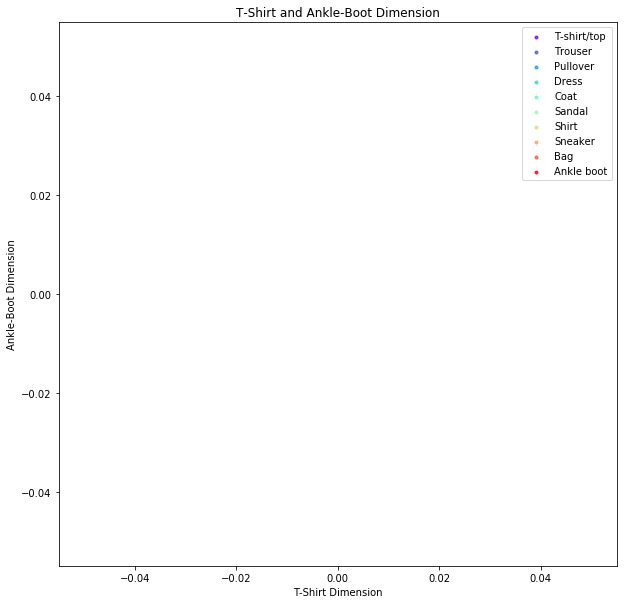

In [218]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

## Examining the Features
Here we aim to answer the more general question: did we generate useful features with the Feature Generation model? And how can we visualize this.

In [ ]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

## Neighbor Visualization
For this we use the TSNE neighborhood embedding to visualize the features on a 2D plane and see if it roughly corresponds to the groups. We use the test data for this example as well since the training has been contaminated

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [ ]:
feature_model.save('fashion_feature_model.h5')

In [ ]:
similarity_model.save('fashion_similarity_model.h5')